# Compare all
This is a place to test all the inference methods and compare them apples-to-apples.

In [15]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join
import numpy as np
import sklearn.neighbors as skn
from sklearn.linear_model import LinearRegression
import tqdm
from scipy.stats import norm
import json
import pandas as pd

import torch
import torch_geometric as pyg
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
import sbi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('style.mcstyle')
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


In [16]:
import ili
from ili.dataloaders import NumpyLoader, StaticNumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.metrics import PlotSinglePosterior, PosteriorCoverage
from ili.utils import IndependentTruncatedNormal, Uniform, IndependentNormal

from tools.plot_tools import binned_plot

In [17]:
def r2logm(r):
    # see preprocessing.ipynb for this measurement
    coef = 0.36752
    intercept = -5.30640
    return (np.log10(r)-intercept)/coef

## Load data

In [18]:
# looking only at dC100 for now
datadir = './data/processed/AMICOdC100'

x = np.load(join(datadir, 'x_sum_test.npy'))
theta = np.load(join(datadir, 'theta_batch_test.npy'))
ids = np.unique(np.load(join(datadir, 'ids_test.npy')))
Ngal = x[:,-1]

print(x.shape, theta.shape, ids.shape)


# prior = Uniform(low=[13.9], high=[14.85])
prior = IndependentNormal(loc=[13.94], scale=[0.373])
# proposal = IndependentTruncatedNormal(
#     low=[13.93], high=[14.8], loc=[13.6993], scale=[0.3166])

(59, 25) (59, 1) (59,)


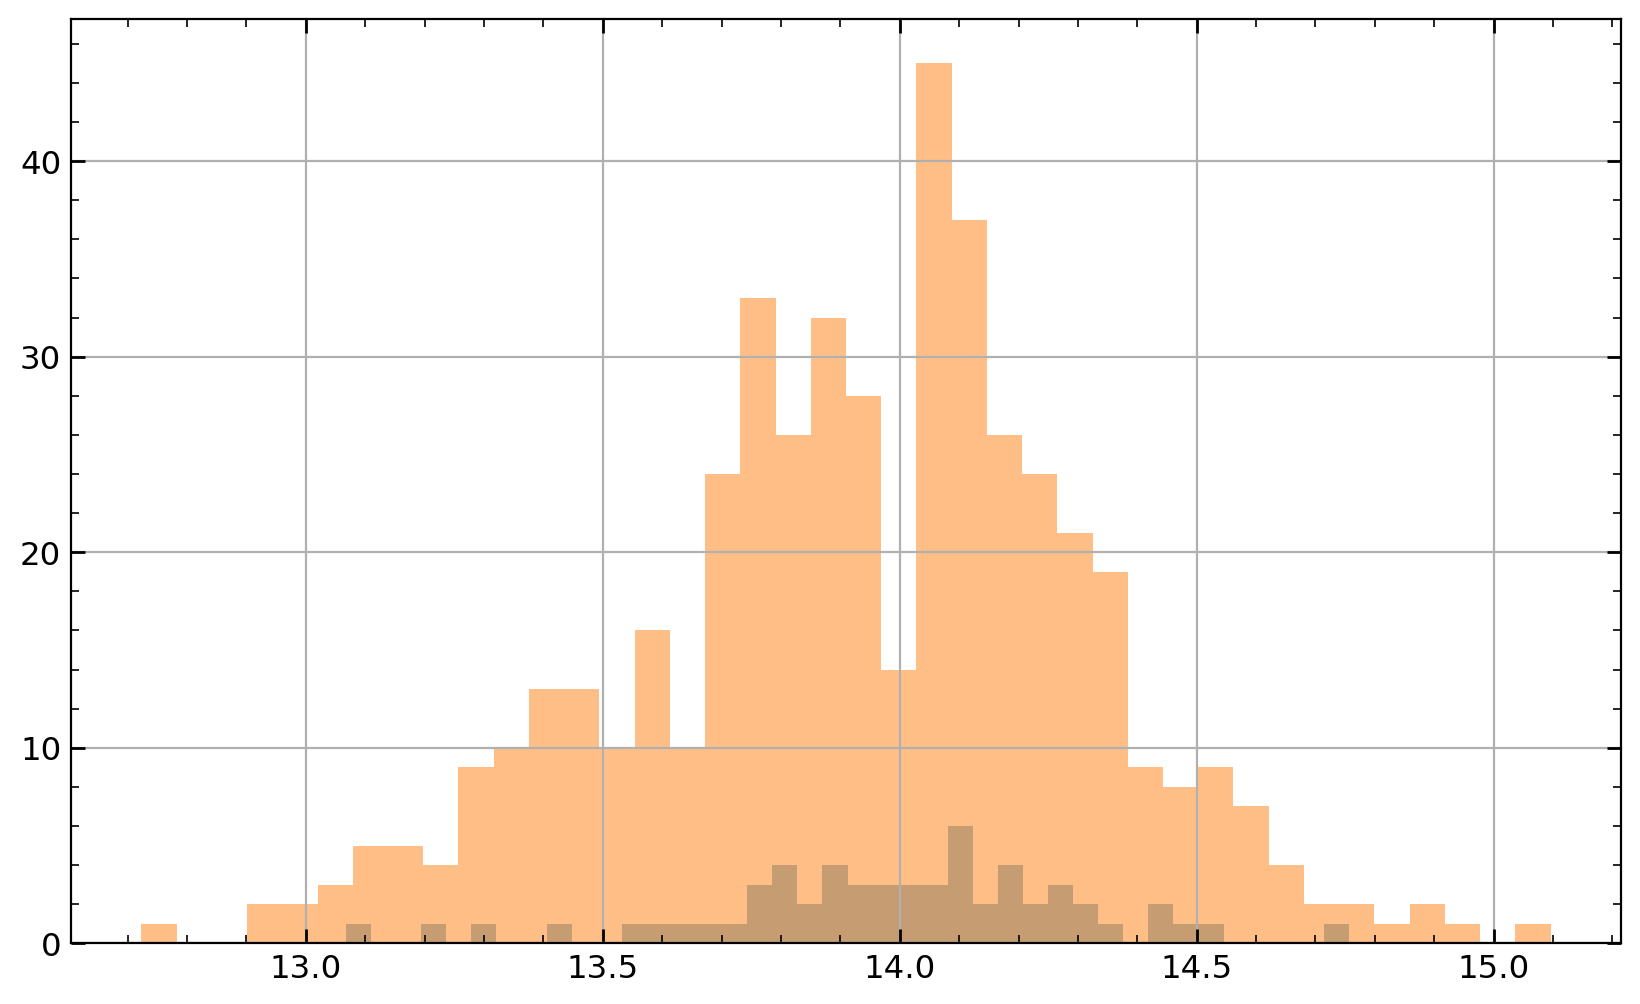

In [64]:
# compare train test
theta_tr = np.load(join(datadir, 'theta_batch_train.npy'))

plt.hist(theta, bins=40, alpha=0.5, label='test')
plt.hist(theta_tr, bins=40, alpha=0.5, label='train');

## Load model predictions

In [19]:
samples = {}

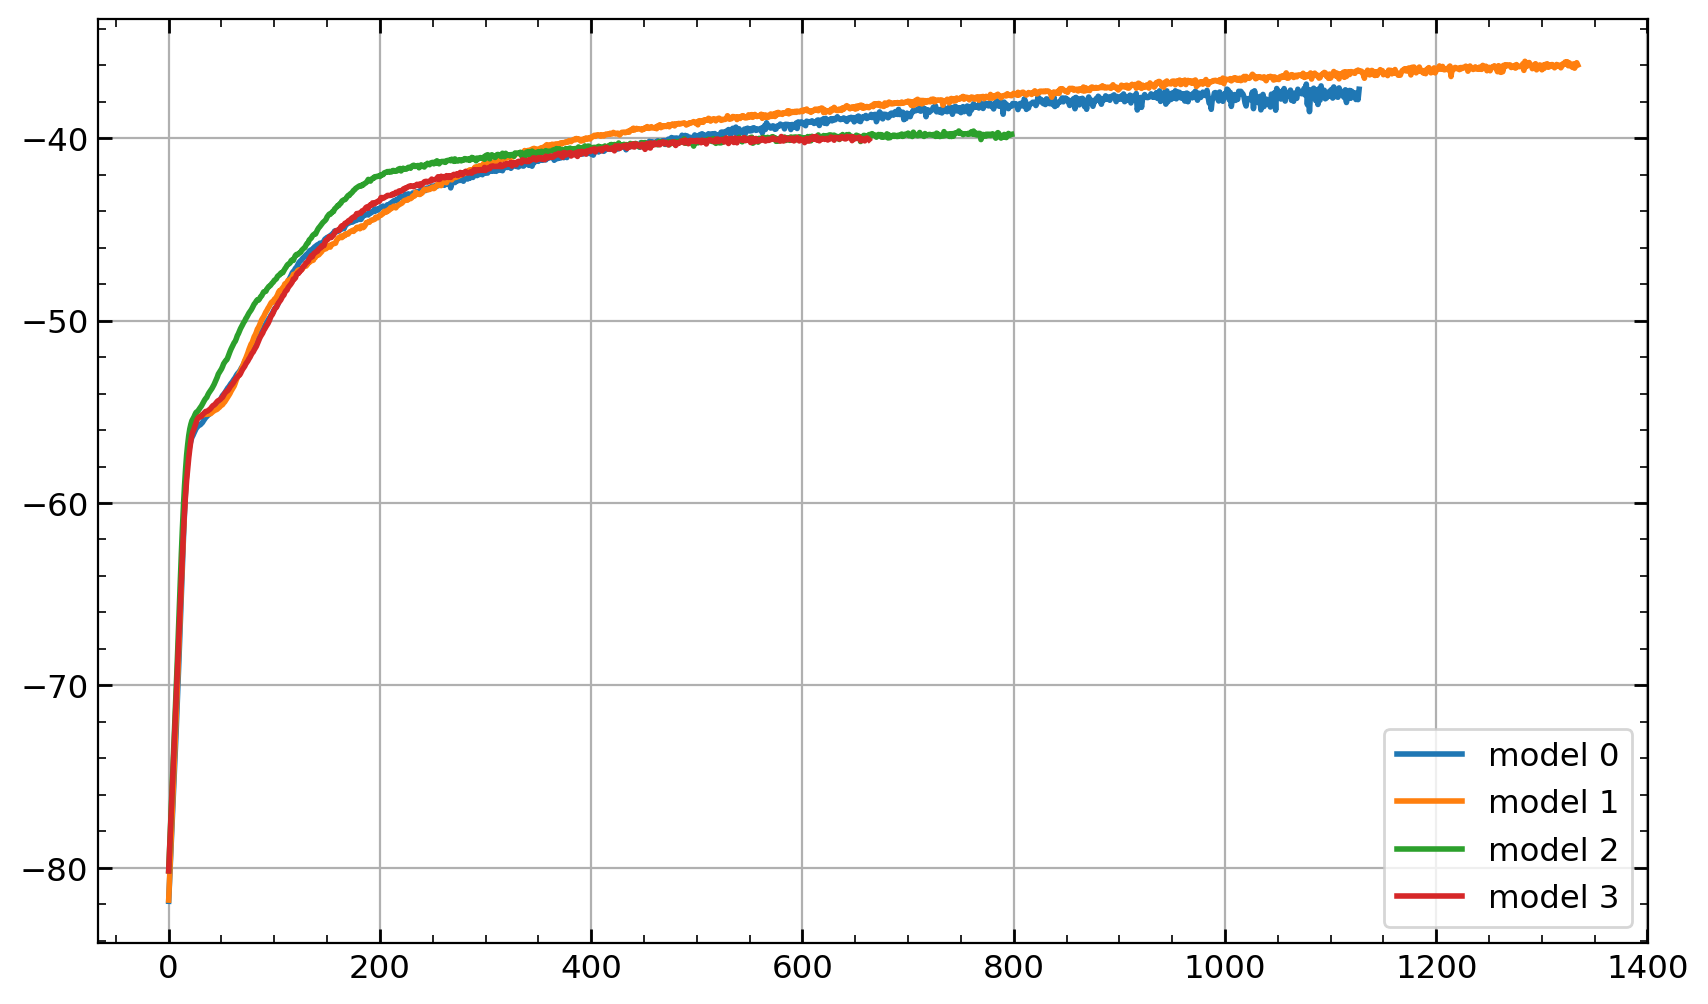

In [6]:
modeldir = './saved_models/summ_nle_dC100/'
summary = json.load(open(join(modeldir, 'summary.json'), 'r'))

for i, x in enumerate(summary):
    plt.plot(x['validation_log_probs'], label=f'model {i}')
plt.legend()

samples['summ'] = np.load(join(modeldir, 'posterior_samples.npy'))

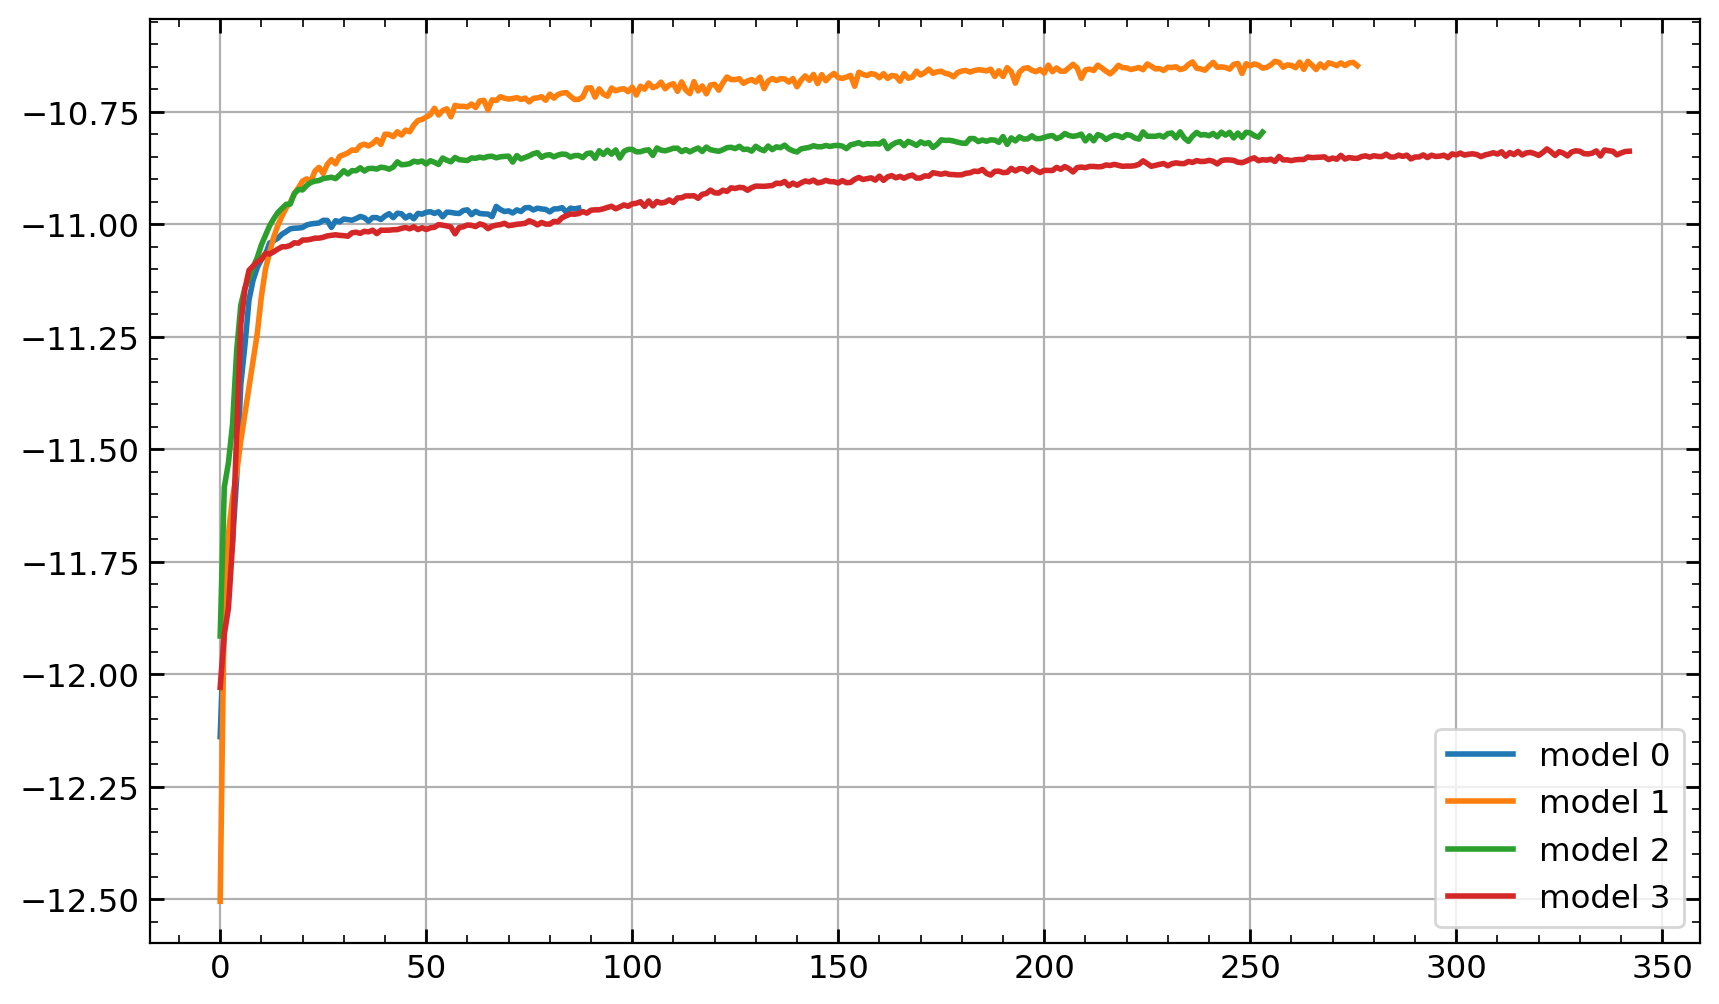

In [7]:
modeldir = './saved_models/gals_nle_dC100/'
summary = json.load(open(join(modeldir, 'summary.json'), 'r'))

for i, x in enumerate(summary):
    plt.plot(x['validation_log_probs'], label=f'model {i}')

plt.legend();

samples['gals'] = np.load(join(modeldir, 'posterior_samples.npy'))

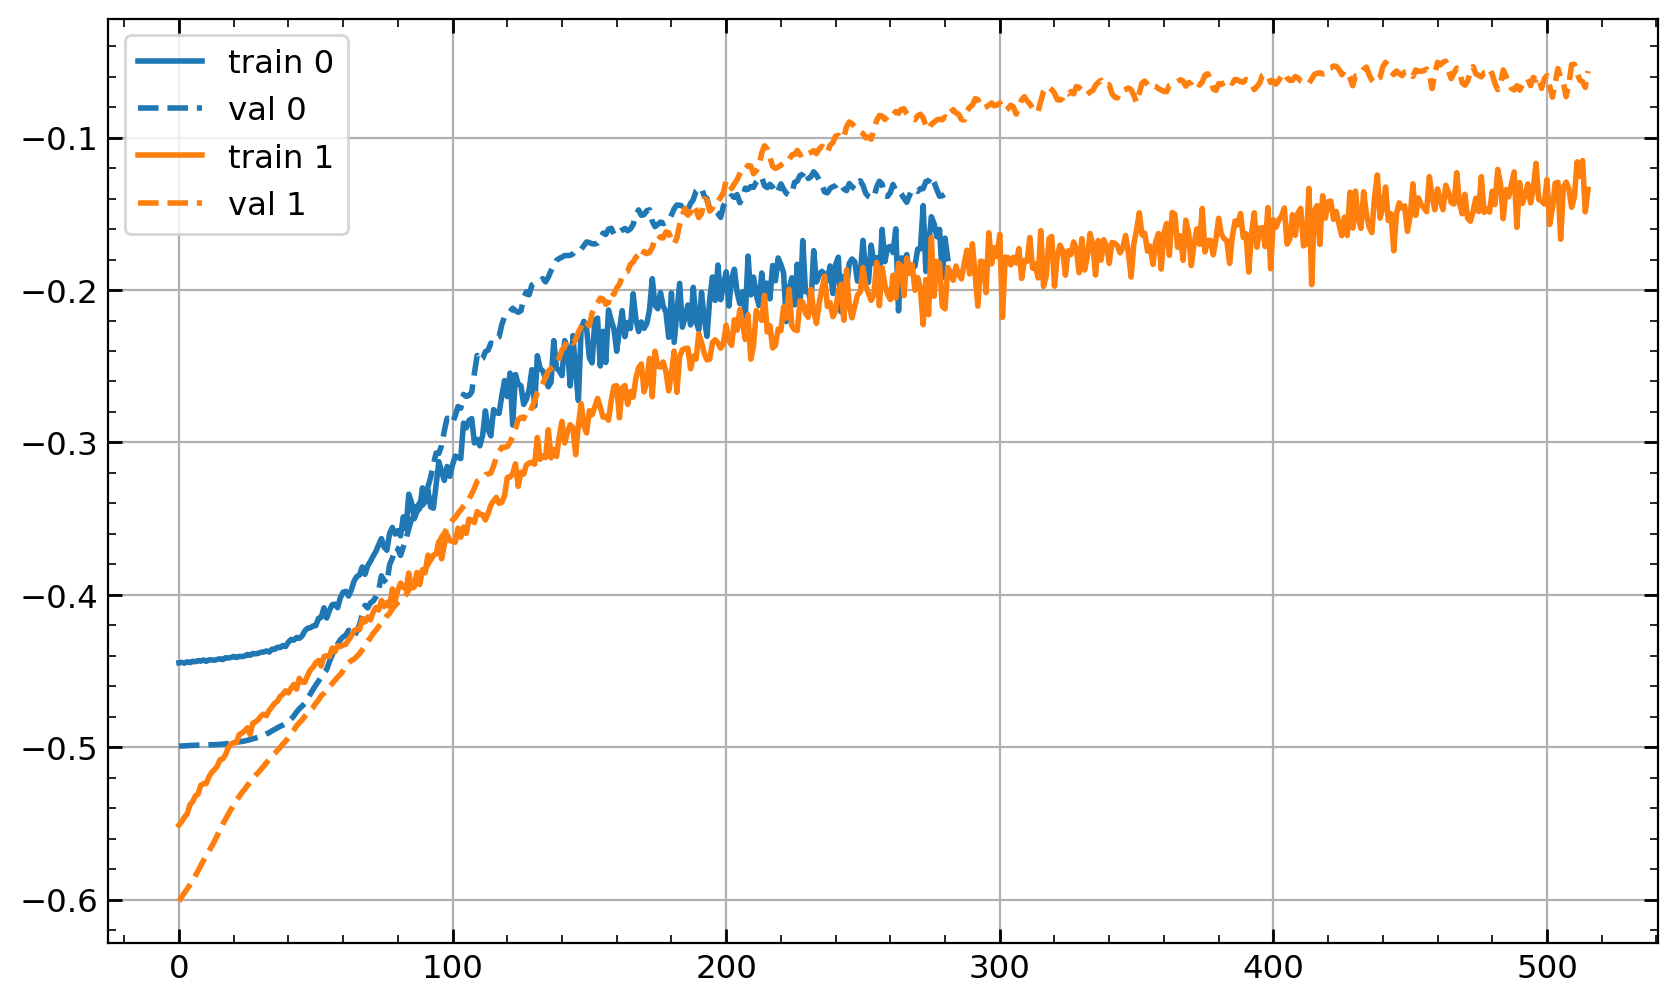

In [65]:
modeldir = './saved_models/gnn_npe_dC100/'
summary = json.load(open(join(modeldir, 'summary.json'), 'r'))

for i, x in enumerate(summary):
    plt.plot(x['training_log_probs'], label=f'train {i}', c=f'C{i}')
    plt.plot(x['validation_log_probs'], label=f'val {i}', c=f'C{i}', ls='--')

plt.legend();

samples['gnn'] = np.load(join(modeldir, 'posterior_samples.npy'))

In [24]:
modeldir = './saved_models/mamposst_dC100/'

# load
cols = [
    'id', 'r200best', 'r200low68', 'r200high68', 'r200low95', 'r200high95',
    'r200true', 'zclu', 'prob68', 'prob95', 'Ngal', 'nll'
]
isamp = pd.read_csv(join(modeldir, 'result_MockFS_AMICO_deep100.dat'), 
                    delimiter=' ', skipinitialspace=True, header=None, names=cols)
isamp['id'] = isamp['id'].astype(int)
isamp.set_index('id', inplace=True)

# convert r200 to logm
for c in isamp.columns:
    if 'r200' not in c:
        continue
    isamp['logm'+c[4:]] = r2logm(isamp[c])

samples['mamp'] = isamp.loc[ids, ['logmlow68', 'logmbest', 'logmhigh68']].values


## Compare predictions

In [66]:
# fit linear regressions
lrs = {}

for m, samps in samples.items():
    if m == 'mamp':
        lr = LinearRegression()
        lr.fit(theta,samps[:,1])
        lrs[m] = lr
        continue

    # all others
    t_ = np.repeat(theta.T, len(samps), axis=0)
    lr = LinearRegression()
    lr.fit(t_.flatten()[:,None], samps.flatten())

    lrs[m] = lr

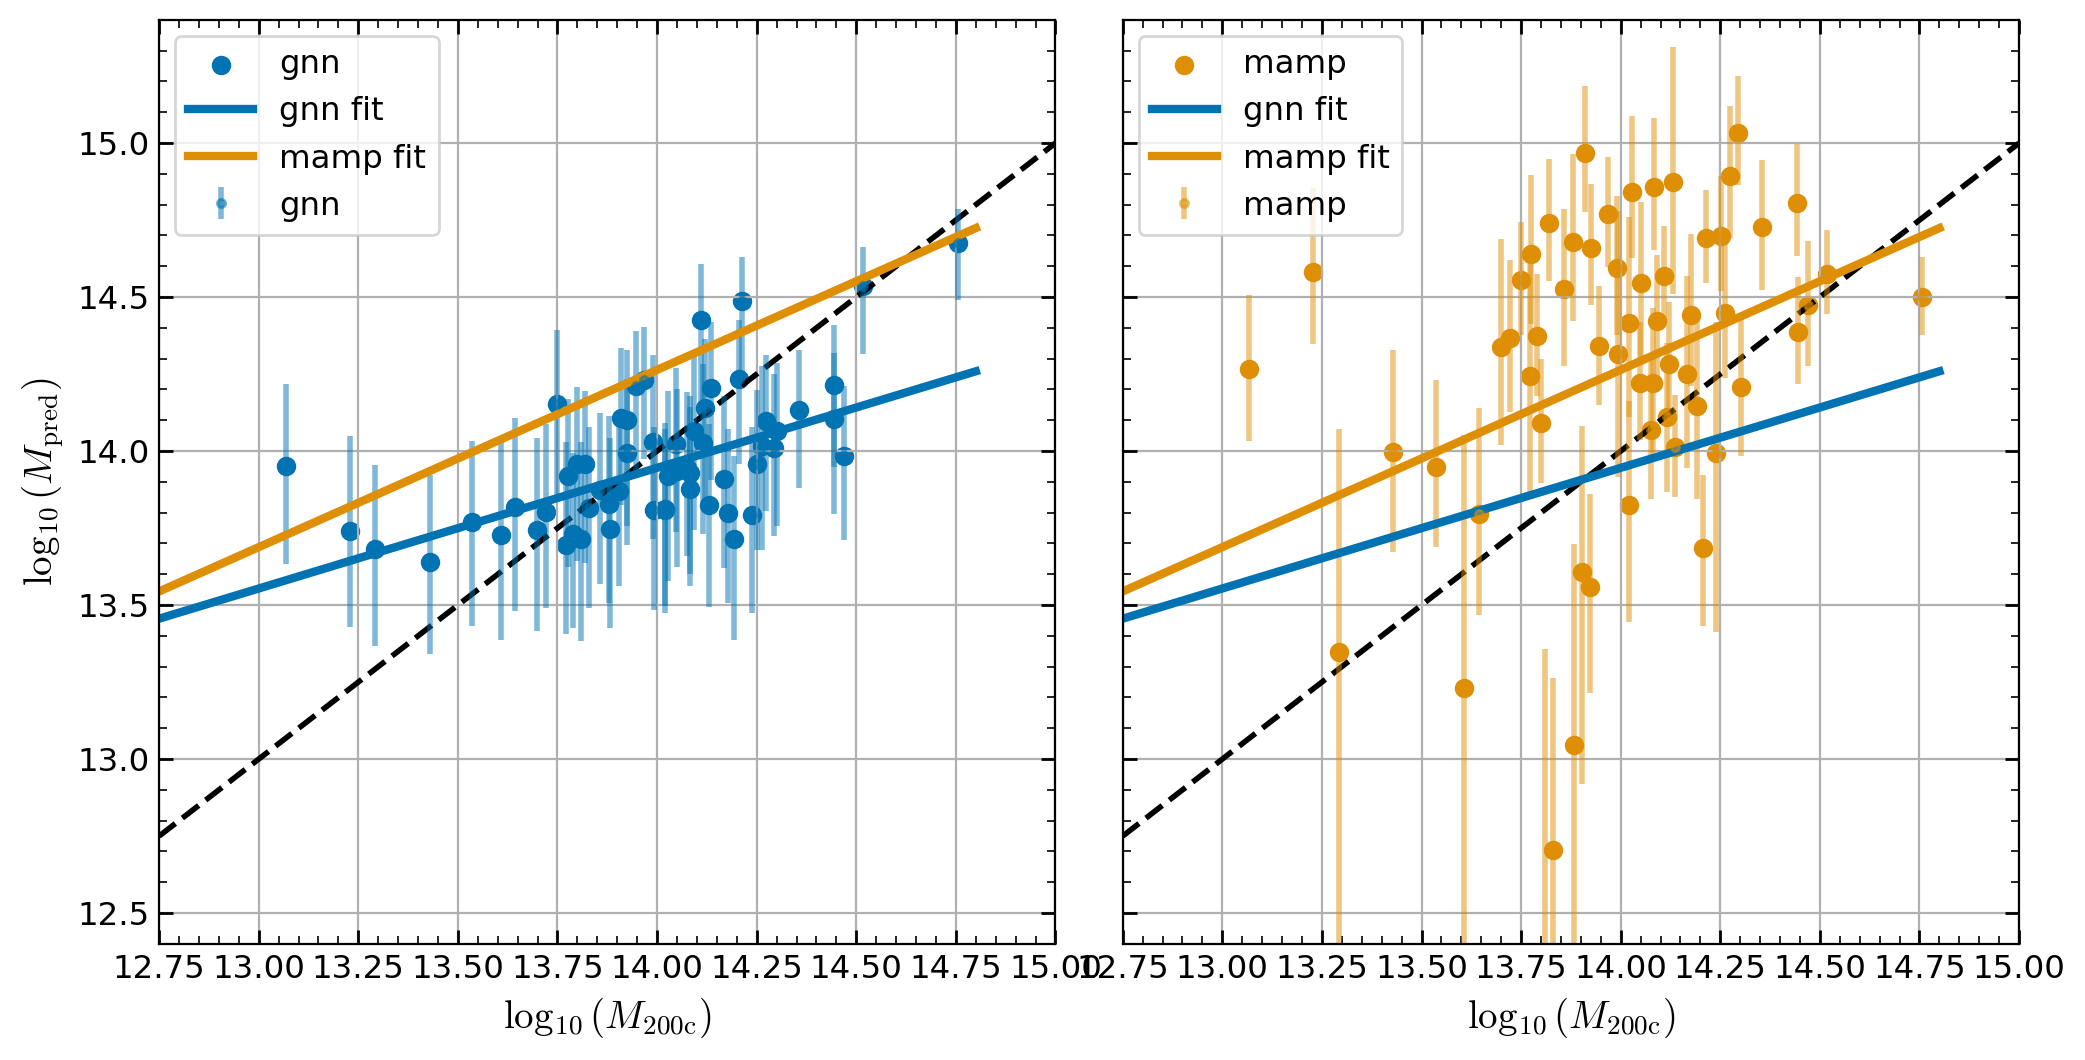

In [74]:
Nm = len(samples)
f, axs = plt.subplots(1, Nm, figsize=(6*Nm,6), sharey=True,
                      gridspec_kw={'wspace':0.075})

colors = sns.color_palette('colorblind', Nm)
for i, (m, samps) in enumerate(samples.items()):
    ax = axs[i]

    ax.plot([12.75,15], [12.75,15], 'k--')
    # plot with error bars
    if m == 'mamp':
        percs = samps.T
    else:
        percs = np.percentile(samps, [16,50,84], axis=0)[...,0]
    x_ = theta[:,0]
    ax.scatter(x_, percs[1], label=m, color=colors[i])

    ax.errorbar(x_, percs[1], yerr=[percs[1]-percs[0], percs[2]-percs[1]],
                label=m, fmt='.', color=colors[i], alpha=0.5)

    # plot weighted linear regression
    x_ = np.linspace(12.5,14.8,100)
    for j, n in enumerate(samples.keys()):
        ax.plot(x_, lrs[n].predict(x_[:,None]), label=f'{n} fit',
                color=colors[j], lw=3)
    
    ax.legend()
    ax.set_xlim(12.75,15)
    ax.set_ylim(12.4,15.4)
    ax.set_xlabel(r'$\log_{10}(M_{\rm 200c})$')
    if i==0:
        ax.set_ylabel(r'$\log_{10}(M_{\rm pred})$');

# axs[0].set_title(r'Summary-based $p(\bar{x}|\theta)$')
# axs[1].set_title(r'Galaxy-based $\prod\ p(x_i|\theta)$')
# axs[2].set_title(r'Graph $p(\theta|\mathbf{x})$');
# axs[3].set_title(r'MAMPOSST');
# f.savefig('images/deepC100_compare.png', dpi=300, bbox_inches='tight')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

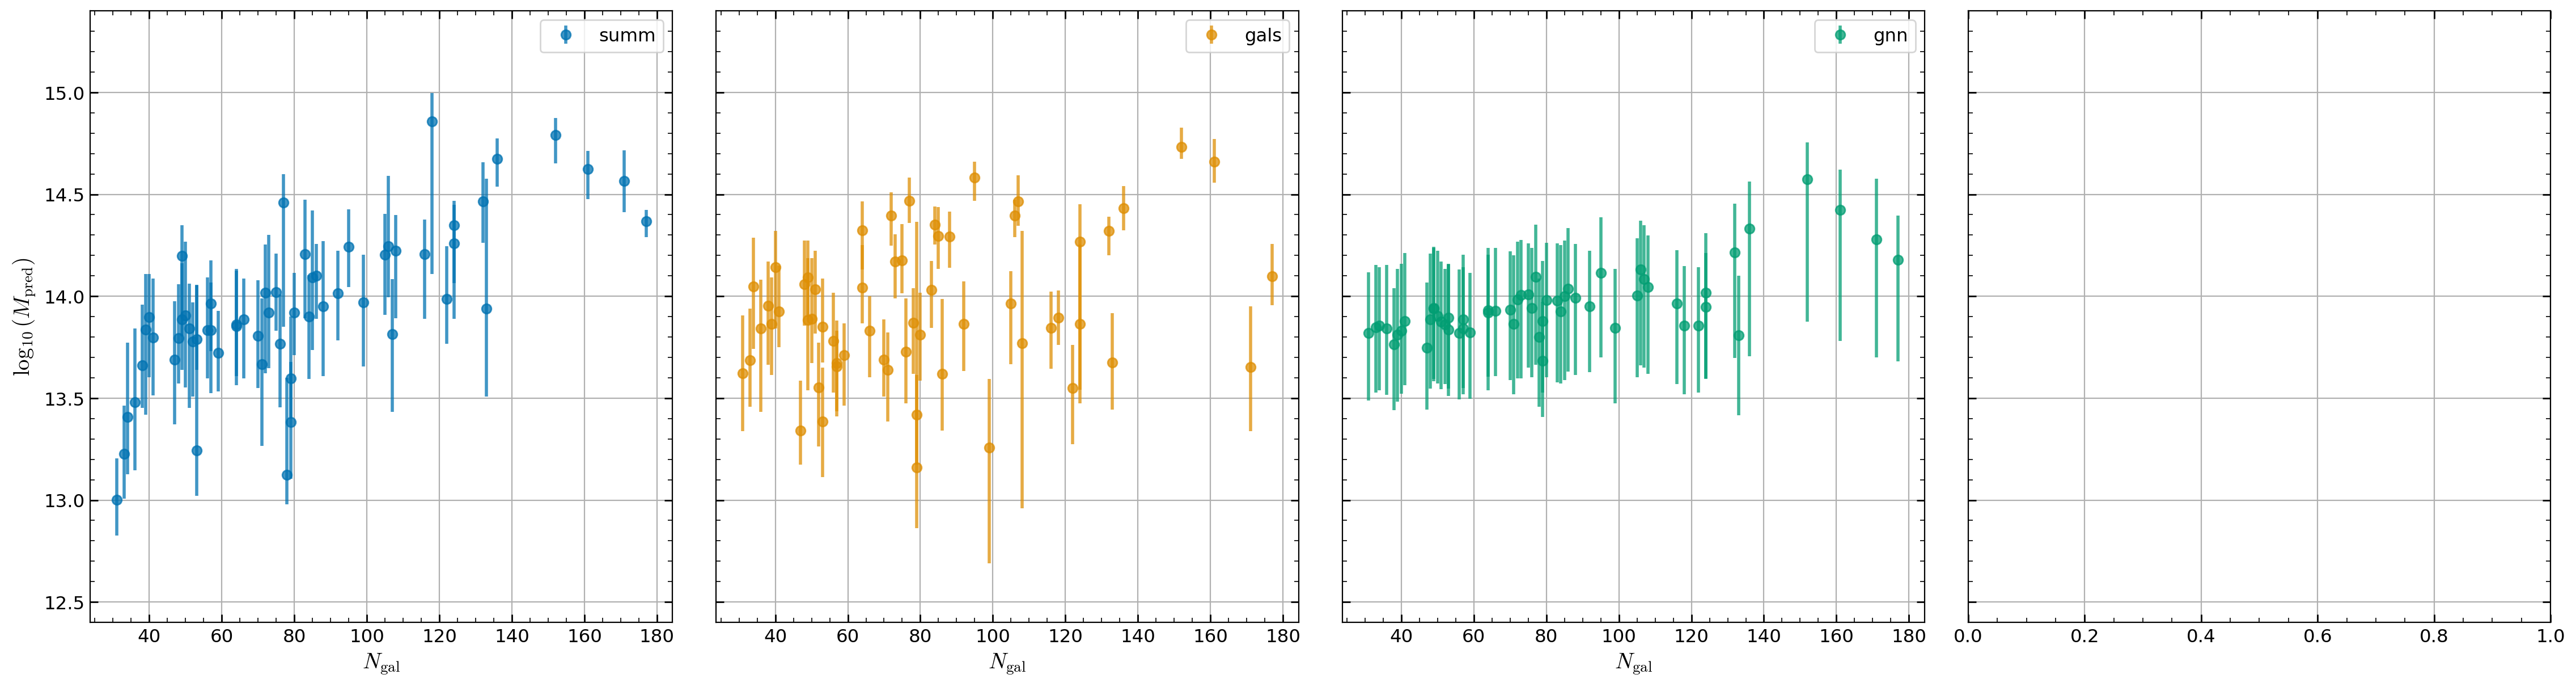

In [143]:
Nm = len(samples)
f, axs = plt.subplots(1, Nm, figsize=(7*Nm,7), sharey=True,
                      gridspec_kw={'wspace':0.075})

colors = sns.color_palette('colorblind', Nm)
for i, (m, samps) in enumerate(samples.items()):
    ax = axs[i]

    # plot with error bars
    median = np.median(samps, axis=0)[:,0]
    percs = np.percentile(samps, [16,84], axis=0)
    x_ = Ngal
    ax.errorbar(x_, median, yerr=[median-percs[0,:,0], percs[1,:,0]-median],
                label=m, fmt='o', color=colors[i], alpha=0.75)
    
    ax.legend()
    # ax.set_xlim(13.9,14.5)
    ax.set_ylim(12.4,15.4)
    ax.set_xlabel(r'$N_{\rm gal}$')
    if i==0:
        ax.set_ylabel(r'$\log_{10}(M_{\rm pred})$');

axs[0].set_title(r'Summary-based $p(\bar{x}|\theta)$')
axs[1].set_title(r'Galaxy-based $\prod\ p(x_i|\theta)$')
axs[2].set_title(r'Graph $p(\theta|\mathbf{x})$');

In [11]:
# Calculate scatter and correlation
t_ = theta[:,0]
sig = np.std(t_ - np.mean(t_))
print(f'Observed scatter: {sig:.3f}')

for m, samps in samples.items():
    mean = np.mean(samps, axis=0)[:,0]
    median = np.median(samps, axis=0)[:,0]

    print(' ')
    print(f'{m} mean scatter: {np.std(t_ - mean):.3f}')
    print(f'{m} median scatter: {np.std(t_ - median):.3f}')
    

Observed scatter: 0.311
 
summ mean scatter: 0.350
summ median scatter: 0.376
 
gals mean scatter: 0.288
gals median scatter: 0.289
 
gnn mean scatter: 0.253
gnn median scatter: 0.254


# Compare all

In [17]:
import pandas as pd
# Compare all
datas = ['wC50', 'wC100', 'dC50', 'dC100']
models = ['msig', 'Pamico', 'summ_nle', 'gals_nle', 'gnn_npe']

stderr = pd.DataFrame(columns=models, index=datas)
rhos = pd.DataFrame(columns=models, index=datas)
fracerr = pd.DataFrame(columns=models, index=datas)

def measure_metrics(x, y):
    sig = np.std(x - y)
    rho = np.corrcoef(x, y)[0,1]
    frac = np.std(10**(x-y))
    return sig, rho, frac

def get_ytest(data):
    dname = f"AMICO{data}"
    datapath = join('data/processed', dname)
    theta_test = np.load(join(datapath, 'theta_batch_test.npy'), allow_pickle=True)
    return theta_test[:,0]

for d in datas:
    out_dir = f'./saved_models/base_{d}/'
    # y = get_ytest(d)
    for m in models[:2]:
        record = np.load(join(out_dir, f'{m}.npz'))
        x, y = record['pred'], record['true']
        sig, rho, frac = measure_metrics(x, y)
        stderr.loc[d,m] = sig
        rhos.loc[d,m] = rho
        fracerr.loc[d,m] = frac

for d in datas:
    y = get_ytest(d)
    for m in models[2:]:
        out_dir = f'./saved_models/{m}_{d}/'
        x = np.load(join(out_dir, f'posterior_samples.npy'))
        x = np.median(x, axis=0)[:,0]
        sig, rho, frac = measure_metrics(x, y)
        stderr.loc[d,m] = sig
        rhos.loc[d,m] = rho
        fracerr.loc[d,m] = frac

In [18]:
best_stderr = stderr.min(axis=1)
best_rhos = rhos.max(axis=1)
best_fracerr = fracerr.min(axis=1)

titles = {
    'msig': r'$M\left(\sigma_{\rm v}\right)$',
    'Pamico': r'$M\left(\sum P_{\rm AMICO}\right)$',
    'summ_nle': r'Summary',# $p(\bar{x}|\theta)$',
    'gals_nle': r'Galaxy',# $\prod\ p(x_i|\theta)$',
    'gnn_npe': r'Graph',# $p(\theta|\mathbf{x})$'
}

for m in models:
    outstr = f'{titles[m]} & '
    for d in datas:
        for t in [stderr.loc[d,m], fracerr.loc[d,m], rhos.loc[d,m]]:
            if (t==best_stderr[d]) or (t==best_rhos[d]) or (t==best_fracerr[d]):
                outstr += f'\\textbf{{{t:.3f}}} & '
            elif t>10:
                outstr += f'{t:.1e} & '
            else:
                outstr += f'{t:.3f} & '

    print(outstr[:-2] + r'\\')


$M\left(\sigma_{\rm v}\right)$ & 0.280 & 0.947 & 0.165 & 0.396 & \textbf{1.533} & 0.194 & 0.309 & 1.263 & 0.150 & 0.301 & 1.545 & 0.268 \\
$M\left(\sum P_{\rm AMICO}\right)$ & 0.276 & \textbf{0.938} & 0.237 & \textbf{0.381} & 1.644 & 0.352 & 0.236 & \textbf{0.681} & 0.648 & \textbf{0.246} & \textbf{0.905} & 0.619 \\
Summary & 0.319 & 1.045 & \textbf{0.479} & 0.619 & 2.671 & 0.254 & 0.268 & 0.827 & 0.620 & 0.376 & 2.449 & 0.422 \\
Galaxy & 0.297 & 1.270 & 0.254 & 0.428 & 1.950 & 0.276 & 0.365 & 1.149 & 0.494 & 0.289 & 1.023 & \textbf{0.620} \\
Graph & \textbf{0.264} & 0.961 & 0.302 & 0.417 & 1.920 & \textbf{0.438} & \textbf{0.233} & 0.710 & \textbf{0.654} & 0.254 & 0.936 & 0.578 \\


In [19]:
data_titles = {
    'wC50': r'Wide C-$50\%$',
    'wC100': r'Wide C-$100\%$',
    'dC50': r'Deep C-$50\%$',
    'dC100': r'Deep C-$100\%$'
}

def plot_lr(x, y, ax):
    lr = LinearRegression().fit(x[:,None], y)
    x_ = np.linspace(12.5,15,100)
    ax.plot(x_, lr.predict(x_[:,None]), '-', color='gray')

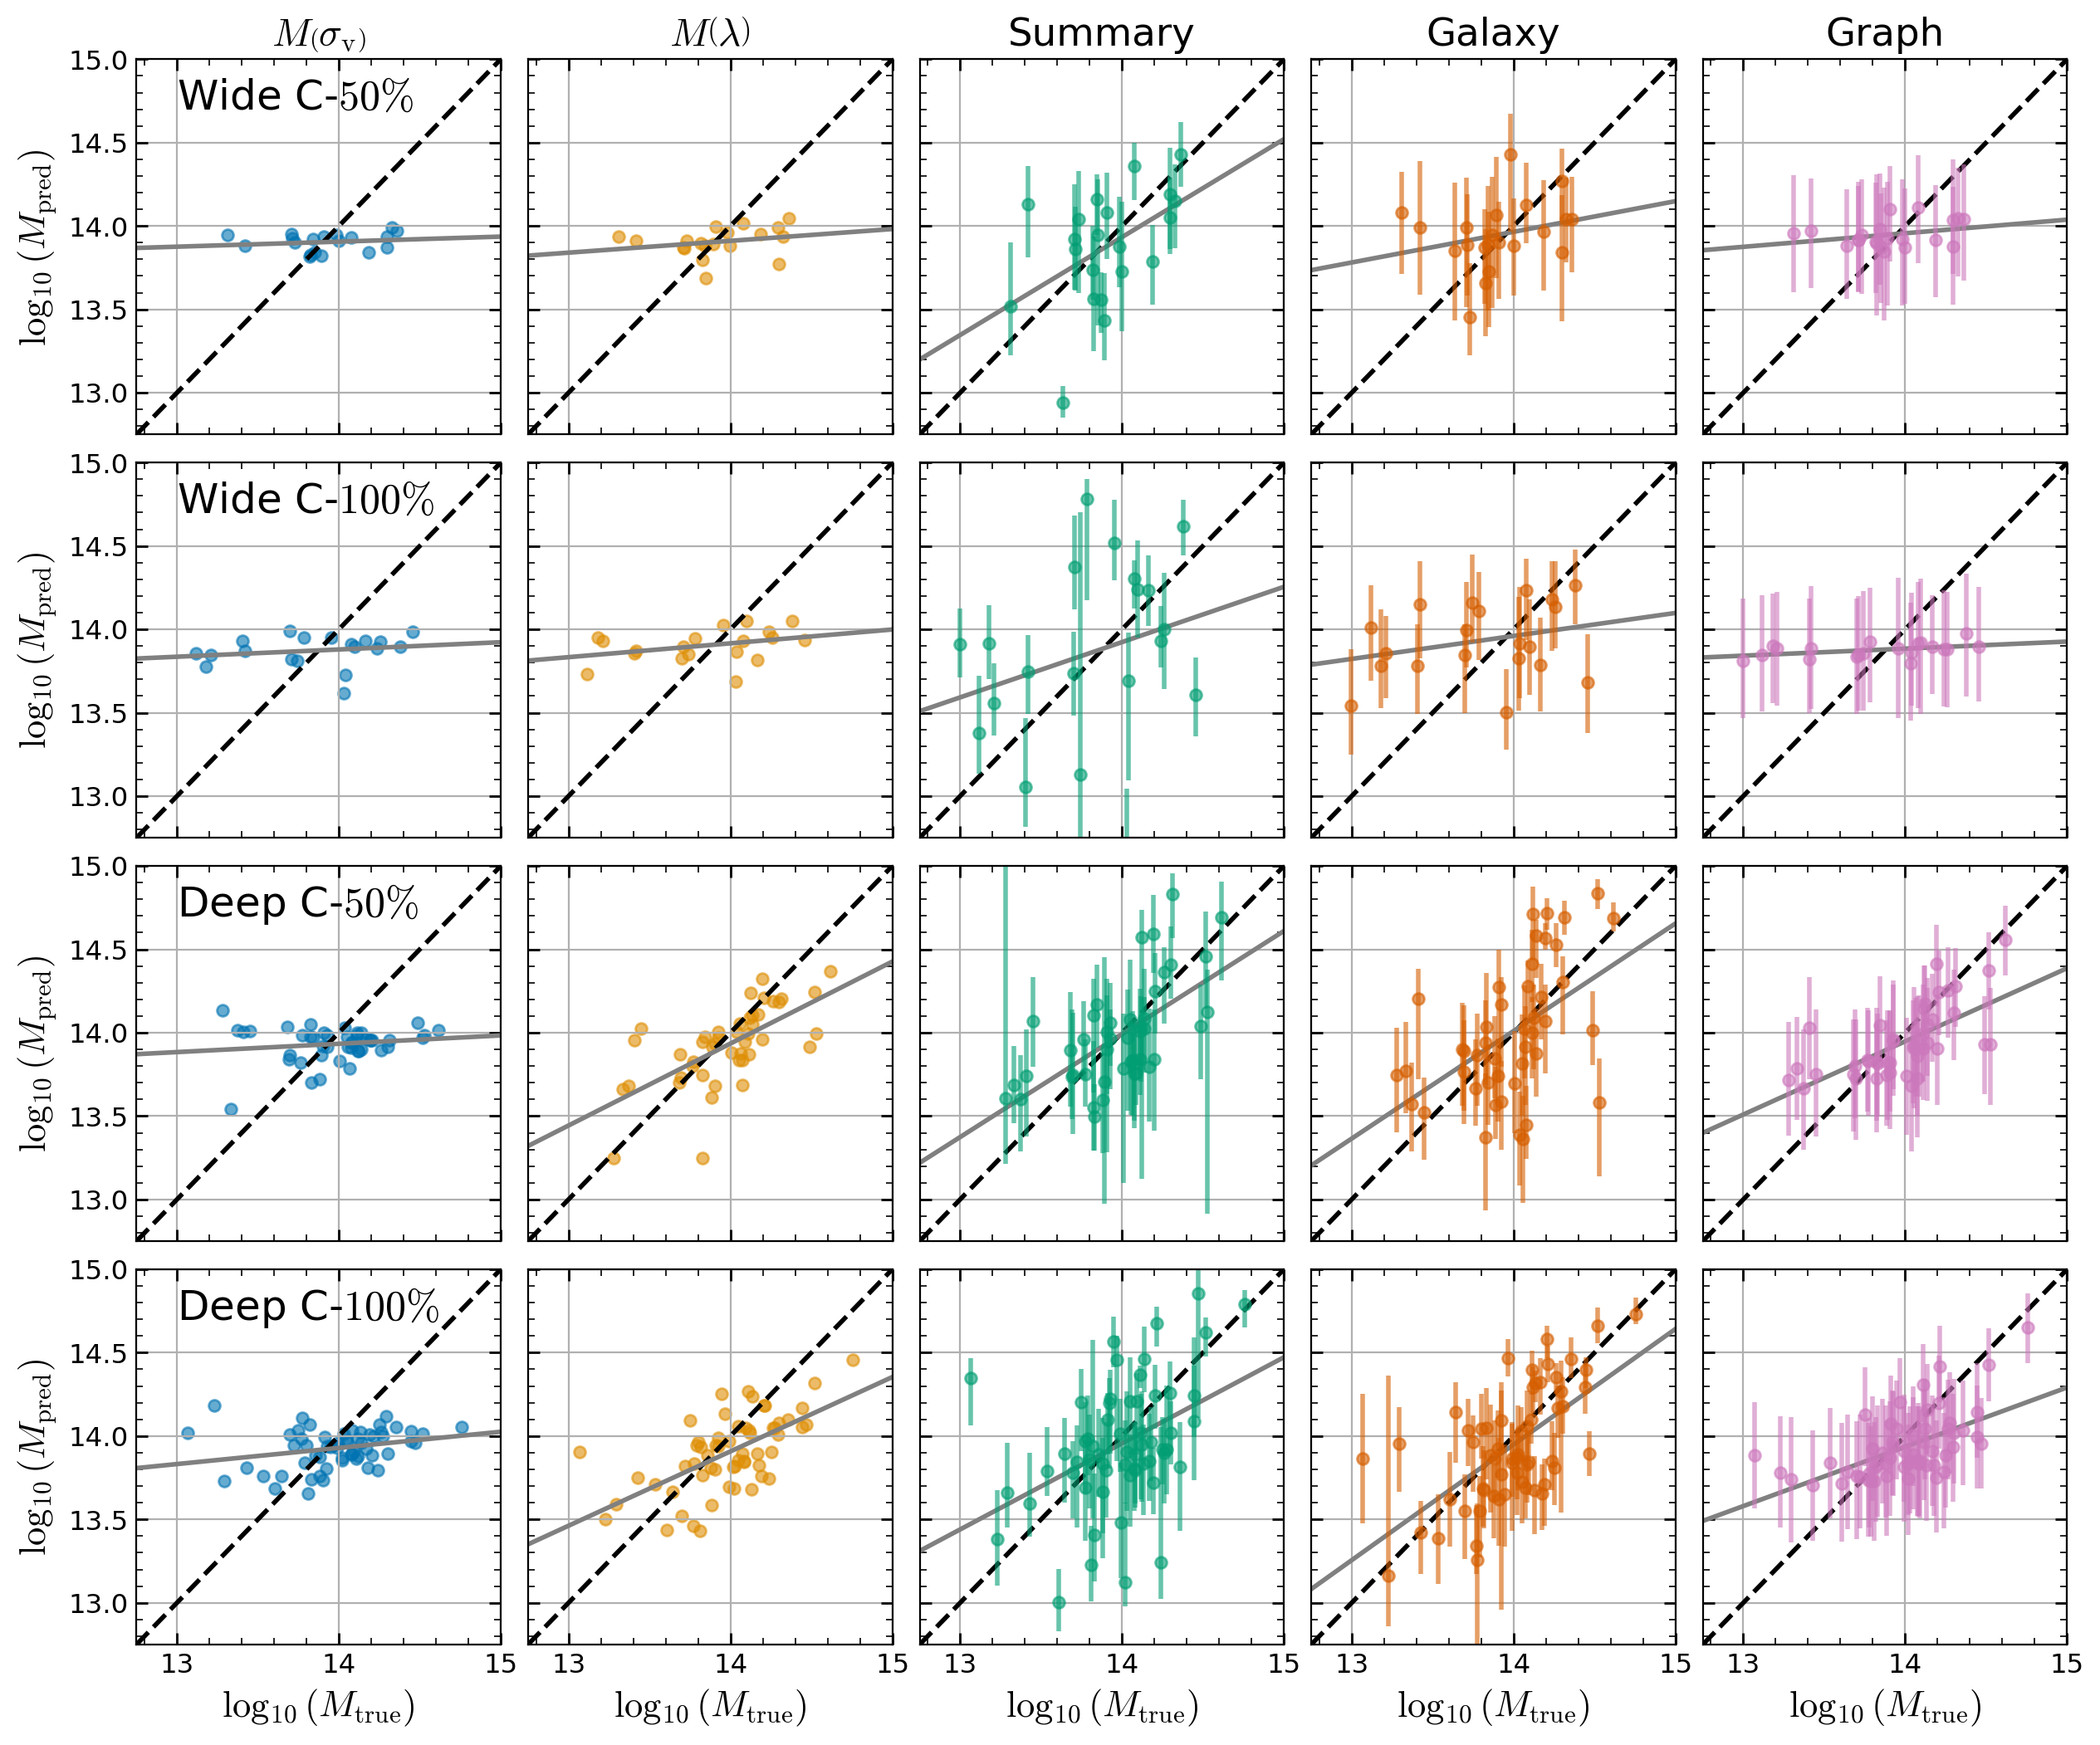

In [22]:
datas = ['wC50', 'wC100', 'dC50', 'dC100']
models = ['msig', 'Pamico', 'summ_nle', 'gals_nle', 'gnn_npe']
titles = {
    'msig': r'$M\left(\sigma_{\rm v}\right)$',
    'Pamico': r'$M\left(\lambda\right)$',
    'summ_nle': r'Summary',# $p(\bar{x}|\theta)$',
    'gals_nle': r'Galaxy',# $\prod\ p(x_i|\theta)$',
    'gnn_npe': r'Graph',# $p(\theta|\mathbf{x})$'
}

Nrows = len(datas)
Ncols = len(models)
colors = sns.color_palette('colorblind', Ncols)

f, axs = plt.subplots(Nrows, Ncols, figsize=(3*Ncols,3.1*Nrows),
                        sharex=True, sharey=True,
                        gridspec_kw={'wspace':0.075, 'hspace':0.075})

for i, d in enumerate(datas):
    for j, m in enumerate(models):
        ax = axs[i,j]
        ax.set_xlim(12.75,15)
        ax.set_ylim(12.75,15)
        ax.plot([12.75,15], [12.75,15], 'k--')

        if j==0:
            ax.set_ylabel(r'$\log_{10}(M_{\rm pred})$', fontsize=16)
            ax.text(13, 14.7, data_titles[d], fontsize=18)
        if i==Nrows-1:
            ax.set_xlabel(r'$\log_{10}(M_{\rm true})$', fontsize=16)
        if i==0:
            ax.set_title(titles[m])

        if j<2:
            out_dir = f'./saved_models/base_{d}/'
            record = np.load(join(out_dir, f'{m}.npz'))
            x, y = record['pred'], record['true']
            ax.scatter(y, x,alpha=0.6, color=colors[j], s=25)
            plot_lr(y, x, ax)
        if j>=2:
            y = get_ytest(d)
            out_dir = f'./saved_models/{m}_{d}/'
            x = np.load(join(out_dir, f'posterior_samples.npy'))[...,0]
            x = np.percentile(x, [16,50,84], axis=0)
            plot_lr(y, x[1], ax)
            ax.errorbar(y, x[1], yerr=[x[1]-x[0], x[2]-x[1]], fmt='o', markersize=5,
                        alpha=0.6, color=colors[j])
            
# f.savefig('./images/AMICO_comparison.pdf', bbox_inches='tight')